# Flat Unrolled Cascade with Data Consistency (DC) - Train

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from scipy.io import loadmat
# Importing our model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam

Using TensorFlow backend.


In [2]:
## PARAMETERS
H,W = 218,170 # Training image dimensions
channels = 2 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)

# Train Set 
train_path = "/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Multi-Coil-Reconstruction-Challenge/Train-mc/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))[0:5]

# Validation set
val_path = "/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Multi-Coil-Reconstruction-Challenge/Val-mc/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Multi-Coil-Reconstruction-Challenge/Train-mc/e13992s4_P08704.7.npy
5
/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Multi-Coil-Reconstruction-Challenge/Val-mc/e14553s5_P44544.7.npy
10


## Load Train Data

In [3]:
offset = 20
nchannels = 12
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    aux = np.load(kspace_files_train[ii])
    nslices =  aux.shape[0]- 2*offset
    ntrain += (nslices*nchannels)

# Load train data    
rec_train = np.zeros((ntrain,H,W,2),dtype = np.float32)
aux_counter = 0
for ii in range(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux_kspace = aux_kspace.transpose(3,0,1,2).reshape(-1,H,W)   
     aux = int(aux_kspace.shape[0] - 2*offset*nchannels)
     aux2 = np.fft.ifft2(aux_kspace[offset*nchannels:-offset*nchannels,:,:])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]
print("Number of training samples", rec_train.shape[0])

Number of training samples 12960


## Load Validation Data

In [5]:
# Get number of samples
nval = 0
for ii in range(len(kspace_files_val)):
    aux = np.load(kspace_files_val[ii])
    nslices =  aux.shape[0]- 2*offset
    nval += (nslices*nchannels)
    
    
kspace_val = np.zeros((nval,H,W,2))
rec_val = np.zeros((nval,H,W,2))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux_kspace = aux_kspace.transpose(3,0,1,2).reshape(-1,H,W)   
    aux = int(aux_kspace.shape[0] - 2*offset*nchannels)
    aux2 = np.fft.ifft2(aux_kspace[offset*nchannels:-offset*nchannels,:,:])
    kspace_val[aux_counter:aux_counter+aux,:,:,0] = aux_kspace[offset*nchannels:-offset*nchannels].real
    kspace_val[aux_counter:aux_counter+aux,:,:,1] = aux_kspace[offset*nchannels:-offset*nchannels].imag
    rec_val[aux_counter:aux_counter+aux,:,:,0] = aux2.real
    rec_val[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
    aux_counter+=aux

print("Number of samples", kspace_val.shape[0])

Number of samples 1600
Kspace  stats 0.09447399196748682 1135.51207500228
Rec stats 4.219917263798448 4.641259267405029


## Initialize Model

In [6]:
epochs = 100
batch_size= 6

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

## Data Augmentation

In [7]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(rec_train[:,:,:,0,np.newaxis], augment=True, seed=seed)
image_datagen2.fit(rec_train[:,:,:,1,np.newaxis], augment=True, seed=seed)

image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2,under_mask,batch_size):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        kspace = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        indexes = np.random.choice(np.arange(under_mask.shape[0], dtype=int), batch_size, replace=true)
        
        kspace2[:,under_mask[indexes],:] = 0
        rec = np.abs(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])[:,:,:,np.newaxis]
        yield(kspace2, rec)

## Train models

Undersampling: 0.82293701171875
Mask type: bool


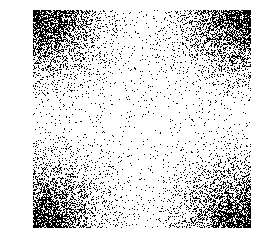

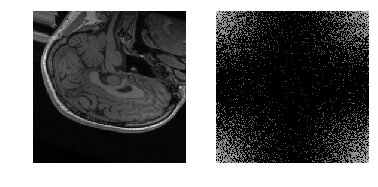

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 48) 912         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 48) 20784       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 48) 20784       conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

Epoch 1/100
668/667 [==============================] - 102s 152ms/step - loss: 0.1037 - val_loss: 0.1111
Epoch 2/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0926 - val_loss: 0.1058
Epoch 3/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0888 - val_loss: 0.1037
Epoch 4/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0867 - val_loss: 0.1011
Epoch 5/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0851 - val_loss: 0.0994
Epoch 6/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0839 - val_loss: 0.0997
Epoch 7/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0831 - val_loss: 0.0995
Epoch 8/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0825 - val_loss: 0.0984
Epoch 9/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0816 - val_loss: 0.0970
Epoch 10/100
668/667 [==============================] - 96s 143

668/667 [==============================] - 96s 143ms/step - loss: 0.0732 - val_loss: 0.0896
Epoch 80/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0731 - val_loss: 0.0903
Epoch 81/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0731 - val_loss: 0.0899
Epoch 82/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0732 - val_loss: 0.0901
Epoch 83/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0732 - val_loss: 0.0901
Epoch 84/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0730 - val_loss: 0.0901
Epoch 85/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0731 - val_loss: 0.0898
Epoch 86/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0731 - val_loss: 0.0897
Epoch 87/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0730 - val_loss: 0.0898
Epoch 88/100
668/667 [==============================] - 96s 143ms/st

Epoch 1/100
668/667 [==============================] - 100s 149ms/step - loss: 0.0494 - val_loss: 0.0645
Epoch 2/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0443 - val_loss: 0.0618
Epoch 3/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0428 - val_loss: 0.0607
Epoch 4/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0421 - val_loss: 0.0603
Epoch 5/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0416 - val_loss: 0.0601
Epoch 6/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0413 - val_loss: 0.0599
Epoch 7/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0410 - val_loss: 0.0594
Epoch 8/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0408 - val_loss: 0.0592
Epoch 9/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0406 - val_loss: 0.0592
Epoch 10/100
668/667 [==============================] - 97s 145

668/667 [==============================] - 97s 145ms/step - loss: 0.0388 - val_loss: 0.0575
Epoch 80/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0389 - val_loss: 0.0574
Epoch 81/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0388 - val_loss: 0.0573
Epoch 82/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0388 - val_loss: 0.0573
Epoch 83/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0388 - val_loss: 0.0572
Epoch 84/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0389 - val_loss: 0.0575
Epoch 85/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0388 - val_loss: 0.0574
Epoch 86/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0388 - val_loss: 0.0574
Epoch 87/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0388 - val_loss: 0.0574
Epoch 88/100
668/667 [==============================] - 97s 145ms/st

Epoch 1/100
668/667 [==============================] - 100s 150ms/step - loss: 0.0641 - val_loss: 0.0758
Epoch 2/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0559 - val_loss: 0.0733
Epoch 3/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0537 - val_loss: 0.0711
Epoch 4/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0526 - val_loss: 0.0698
Epoch 5/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0516 - val_loss: 0.0695
Epoch 6/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0509 - val_loss: 0.0694
Epoch 7/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0505 - val_loss: 0.0685
Epoch 8/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0498 - val_loss: 0.0681
Epoch 9/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0496 - val_loss: 0.0683
Epoch 10/100
668/667 [==============================] - 97s 145

668/667 [==============================] - 97s 145ms/step - loss: 0.0445 - val_loss: 0.0627
Epoch 80/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0445 - val_loss: 0.0627
Epoch 81/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0446 - val_loss: 0.0628
Epoch 82/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0445 - val_loss: 0.0630
Epoch 83/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0445 - val_loss: 0.0628
Epoch 84/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0446 - val_loss: 0.0629
Epoch 85/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0444 - val_loss: 0.0627
Epoch 86/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0445 - val_loss: 0.0626
Epoch 87/100
668/667 [==============================] - 97s 144ms/step - loss: 0.0443 - val_loss: 0.0625
Epoch 88/100
668/667 [==============================] - 97s 145ms/st

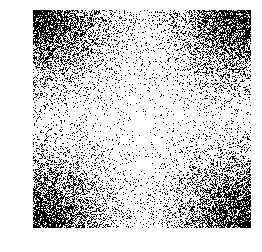

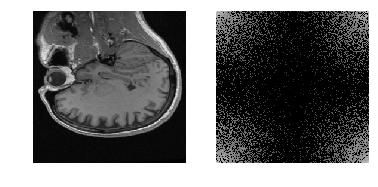

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 256, 256, 48) 912         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 256, 256, 48) 20784       conv2d_133[0][0]                 
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 48) 20784       conv2d_134[0][0]                 
__________________________________________________________________________________________________
max_poolin

Epoch 1/100
668/667 [==============================] - 100s 150ms/step - loss: 0.1019 - val_loss: 0.1017
Epoch 2/100
668/667 [==============================] - 96s 144ms/step - loss: 0.0849 - val_loss: 0.0938
Epoch 3/100
668/667 [==============================] - 96s 144ms/step - loss: 0.0800 - val_loss: 0.0918
Epoch 4/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0776 - val_loss: 0.0893
Epoch 5/100
668/667 [==============================] - 96s 144ms/step - loss: 0.0757 - val_loss: 0.0877
Epoch 6/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0743 - val_loss: 0.0864
Epoch 7/100
668/667 [==============================] - 96s 144ms/step - loss: 0.0734 - val_loss: 0.0865
Epoch 8/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0727 - val_loss: 0.0859
Epoch 9/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0718 - val_loss: 0.0862
Epoch 10/100
668/667 [==============================] - 96s 143

668/667 [==============================] - 96s 143ms/step - loss: 0.0631 - val_loss: 0.0770
Epoch 80/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0629 - val_loss: 0.0775
Epoch 81/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0631 - val_loss: 0.0773
Epoch 82/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0629 - val_loss: 0.0776
Epoch 83/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0630 - val_loss: 0.0773
Epoch 84/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0627 - val_loss: 0.0772
Epoch 85/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0630 - val_loss: 0.0768
Epoch 86/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0631 - val_loss: 0.0770
Epoch 87/100
668/667 [==============================] - 96s 143ms/step - loss: 0.0629 - val_loss: 0.0768
Epoch 88/100
668/667 [==============================] - 96s 143ms/st

Epoch 1/100
668/667 [==============================] - 102s 153ms/step - loss: 0.0406 - val_loss: 0.0518
Epoch 2/100
668/667 [==============================] - 98s 147ms/step - loss: 0.0352 - val_loss: 0.0505
Epoch 3/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0342 - val_loss: 0.0495
Epoch 4/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0334 - val_loss: 0.0492
Epoch 5/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0329 - val_loss: 0.0485
Epoch 6/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0326 - val_loss: 0.0483
Epoch 7/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0326 - val_loss: 0.0486
Epoch 8/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0322 - val_loss: 0.0482
Epoch 9/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0322 - val_loss: 0.0480
Epoch 10/100
668/667 [==============================] - 98s 146

668/667 [==============================] - 97s 146ms/step - loss: 0.0306 - val_loss: 0.0469
Epoch 80/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0307 - val_loss: 0.0468
Epoch 81/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0307 - val_loss: 0.0470
Epoch 82/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0307 - val_loss: 0.0471
Epoch 83/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0306 - val_loss: 0.0468
Epoch 84/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0307 - val_loss: 0.0470
Epoch 85/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0307 - val_loss: 0.0467
Epoch 86/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0306 - val_loss: 0.0470
Epoch 87/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0306 - val_loss: 0.0469
Epoch 88/100
668/667 [==============================] - 97s 146ms/st

Epoch 1/100
668/667 [==============================] - 102s 152ms/step - loss: 0.0560 - val_loss: 0.0649
Epoch 2/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0469 - val_loss: 0.0613
Epoch 3/100
668/667 [==============================] - 98s 146ms/step - loss: 0.0448 - val_loss: 0.0600
Epoch 4/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0433 - val_loss: 0.0584
Epoch 5/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0426 - val_loss: 0.0582
Epoch 6/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0419 - val_loss: 0.0575
Epoch 7/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0414 - val_loss: 0.0569
Epoch 8/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0412 - val_loss: 0.0574
Epoch 9/100
668/667 [==============================] - 97s 146ms/step - loss: 0.0408 - val_loss: 0.0566
Epoch 10/100
668/667 [==============================] - 97s 146

668/667 [==============================] - 97s 145ms/step - loss: 0.0360 - val_loss: 0.0517
Epoch 80/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0360 - val_loss: 0.0520
Epoch 81/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0360 - val_loss: 0.0518
Epoch 82/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0360 - val_loss: 0.0523
Epoch 83/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0358 - val_loss: 0.0519
Epoch 84/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0361 - val_loss: 0.0520
Epoch 85/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0359 - val_loss: 0.0516
Epoch 86/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0359 - val_loss: 0.0521
Epoch 87/100
668/667 [==============================] - 97s 145ms/step - loss: 0.0360 - val_loss: 0.0519
Epoch 88/100
668/667 [==============================] - 97s 145ms/st

In [8]:
under_rates = ['16.7','20','25','33','50']
wnet_models = ['k','i',\
               'kk',,'ii','ik','ki',\
               'kkk','iii','kii','kik','kki','iik','iki','iik',\
               'kkkk','kiii','kkii','kkik','kkki','kiik','kiki','kiik',\
               'ikkk','iiii','ikii','ikik','ikki','iiik','iiki','iiik']

for under in under_rates:
    # undersampling patterns - uncentred k-space
    var_sampling_mask = np.load("../Data/sampling_mask_" + under \
                            + "perc.npy")   
    mask = np.concatenate((var_sampling_mask[:,:,np.newaxis],\
                       var_sampling_mask[:,:,np.newaxis]),\
                      axis = -1) > 0
    mask = mask.astype(np.float32)
    print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
    print("Mask type:",  var_sampling_mask.dtype)
    plt.figure()
    plt.imshow(mask[:,:,0],cmap = "gray")
    plt.axis("off")
    plt.show()
    
    # combine generators into one which yields image and masks
    combined = combine_generator(image_generator1,image_generator2, var_sampling_mask)

    # sample data augmentation
    for ii in combined:
        plt.figure()
        plt.subplot(121)
        plt.imshow(ii[1][5,:,:,0],cmap = 'gray')
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(np.log(1+np.abs(ii[0][5,:,:,0] + 1j*ii[0][5,:,:,1])),cmap = 'gray')
        plt.axis("off")
        plt.show()
        break
    kspace_val_copy = kspace_val.copy()
    kspace_val_copy[:,var_sampling_mask,:] = 0
    for wnet_model in wnet_models:
        if wnet_model == 'kk':
            model = kk_wnet(mask)
        elif wnet_model == 'ii':
            model = ii_wnet(mask)
        elif wnet_model == 'ki':
            model = ki_wnet(mask)
        else:
            print("invalid option")

        opt = Adam()
        model.compile(loss = fsnet.nrmse_min_max,optimizer=opt)
        model_name = "./Models-wnet/" + wnet_model + "_wnet_" + under + ".hdf5"
        
        if os.path.isfile(model_name):
            model.load_weights(model_name)
        print(model.summary())
        print(model_name)
        # Checkpoint callback to save model  along the epochs
        checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

        
        hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=rec_train.shape[0] / batch_size,
                     verbose=1,
                     validation_data= (kspace_val_copy,rec_val),
                     callbacks=[checkpoint,earlyStopping])